### CONSTANTS

In [1]:
import torch

num_units = 700          # NUMBER OF NEURONS (SENSOR_SIZE)             
num_samples = 100       # NUMBER OF SAMPLE IN THE DATASET 
time_window= 1000        # TIME STEPS FOR TEMPORAL PROCESSING
input_size = 700        # NUMBER OF INPUT NEURONS (SAME AS NUM_UNITS)
num_classes = 20   
num_epochs = 10
learning_rate = 0.0001
batch_size = 12         
beta1 = 0.8             # 1 DECAY FACTOR FOR RLeaky 1
beta2 = 0.89            # 2 DECAY FACTOR FOR RLeaky 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/ayush/Desktop/snn_working_memory_edge_ai/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


### SETUP DATASET

In [2]:
import os
import urllib.request
import gzip, shutil

cache_dir = os.path.expanduser("~/data")
os.makedirs(cache_dir, exist_ok=True)

def download_and_extract_shd():
    url = "https://zenkelab.org/datasets/shd_train.h5.gz"
    gz_file_path = os.path.join(cache_dir, "shd_train.h5.gz")
    hdf5_file_path = gz_file_path[:-3]

    if not os.path.exists(hdf5_file_path):
        print("Downloading SHD dataset...")
        urllib.request.urlretrieve(url, gz_file_path)
        
        # Decompress .gz file
        print(f"Decompressing {gz_file_path}...")
        with gzip.open(gz_file_path, 'rb') as f_in, open(hdf5_file_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
        print(f"Decompressed to {hdf5_file_path}")
    else:
        print(f"{hdf5_file_path} already exists.")
    
    return hdf5_file_path

shd_train_file = download_and_extract_shd()
shd_train_file

/home/ayush/data/shd_train.h5 already exists.


'/home/ayush/data/shd_train.h5'

In [3]:
import h5py

def explore_h5_file(file_path):
    with h5py.File(file_path, 'r') as file:
        # Recursive function to explore groups and datasets
        def print_group(name, obj):
            print(f"Group: {name}")
            if isinstance(obj, h5py.Group):
                for key in obj.keys():
                    print_group(f"{name}/{key}", obj[key])
            else:
                print(f"  Dataset: {name}, Shape: {obj.shape}, Dtype: {obj.dtype}")

        print_group('/', file)
        
explore_h5_file(shd_train_file)


Group: /
Group: //extra
Group: //extra/keys
  Dataset: //extra/keys, Shape: (20,), Dtype: |S6
Group: //extra/meta_info
Group: //extra/meta_info/age
  Dataset: //extra/meta_info/age, Shape: (12,), Dtype: uint16
Group: //extra/meta_info/body_height
  Dataset: //extra/meta_info/body_height, Shape: (12,), Dtype: uint16
Group: //extra/meta_info/gender
  Dataset: //extra/meta_info/gender, Shape: (12,), Dtype: |S6
Group: //extra/speaker
  Dataset: //extra/speaker, Shape: (8156,), Dtype: uint16
Group: //labels
  Dataset: //labels, Shape: (8156,), Dtype: uint16
Group: //spikes
Group: //spikes/times
  Dataset: //spikes/times, Shape: (8156,), Dtype: object
Group: //spikes/units
  Dataset: //spikes/units, Shape: (8156,), Dtype: object


In [4]:
import h5py
import numpy as np

def load_spikes_and_labels(hdf5_file_path):
    with h5py.File(hdf5_file_path, 'r') as f:
        
        labels = np.array(f['/labels'])
        
        spike_units = np.array(f['/spikes/units'], dtype=object) 
        
        spike_times = np.array(f['/spikes/times'], dtype=object)
        
    return spike_units, spike_times, labels

In [5]:
import torch

spike_units, spike_times, labels = load_spikes_and_labels(shd_train_file)


spike_units_list = [torch.tensor(units, dtype=torch.float32) for units in spike_units]
spike_times_list = [torch.tensor(times, dtype=torch.float32) for times in spike_times]


# Limit the number of samples to process (ex. 500 samples)
spike_units_list = spike_units_list[:num_samples]
spike_times_list = spike_times_list[:num_samples]
labels = labels[:num_samples]

In [10]:
import plotly.express as px
import pandas as pd

spike_times = spike_times_list[12]
spike_units = spike_units_list[12]

df = pd.DataFrame({
    'Spike Time (s)': spike_times,
    'Neuron ID': spike_units
})

fig = px.scatter(df, x='Spike Time (s)', y='Neuron ID',
                 title='Neuron Activity (Spike Raster Plot)',
                 color='Neuron ID', color_continuous_scale='Viridis',
                 labels={'Neuron ID': 'Neuron ID', 'Spike Time (s)': 'Time (s)'})

# Update layout for a clean, sleek look
fig.update_layout(
    title_font=dict(size=24, family='Arial', color='black'),
    xaxis_title_font=dict(size=18, family='Arial'),
    yaxis_title_font=dict(size=18, family='Arial'),
    font=dict(size=14, color='black'),
    plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridcolor='lightgray')
)

fig.show()

### GENERATE SPIKE TENSOR & LABEL TENSOR from SPIKE UNITS, SPIKE TIMES

In [45]:

def generate_spike_tensor(spike_units, spike_times, num_units, time_window):
    """
    Convert spike units and spike times to spike train tensors.
    
    Parameters:
    - spike_units: tensor of spike units (neuron IDs)
    - spike_times: tensor of spike times (in ms)
    - num_units: number of possible units (e.g., 700 in SHD)
    - time_window: total time of the spike train (in ms)
    
    Returns:
    - A spike tensor of shape [time_window, num_units]
    """
    spike_tensor = torch.zeros((time_window, num_units))

    for unit, time in zip(spike_units, spike_times):
        # Time is rounded to the nearest ms"
        spike_time = int(time.item())
        if spike_time < time_window:
            spike_tensor[spike_time, int(unit.item())] = 1

    return spike_tensor

In [46]:
spike_list = [generate_spike_tensor(spike_units_list[i], spike_times_list[i], num_units, time_window) for i in range(num_samples)]
labels_tensor = [torch.tensor(i, dtype=torch.long).unsqueeze(0) for i in labels]

In [47]:
print("SPIKE LIST: ", spike_list, "\n\n")
print("LABEL TENSOR: ", labels_tensor)

SPIKE LIST:  [tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[1., 0., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[1., 0., 1.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        

### RSNN MODEL

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import snntorch as snn
from snntorch import surrogate

spike_grad = surrogate.straight_through_estimator() 

class RSNN(nn.Module):
    def __init__(self, input_size, num_classes, time_window):
        super(RSNN, self).__init__()
    
        # Define layers
        self.fc1 = nn.Linear(input_size, 512)
        self.rlif1 = snn.RLeaky(beta=beta1, all_to_all=True, linear_features=512, spike_grad=spike_grad, learn_beta=True)

        self.fc2 = nn.Linear(512, num_classes)
        self.rlif2 = snn.RLeaky(beta=beta2, all_to_all=True, linear_features=num_classes, spike_grad=spike_grad, learn_beta=True)

        self.time_window = time_window

    def forward(self, x):
        # Initialize spikes and membrane potential for both layers
        spk1, mem1 = torch.ones(512, device=x.device) * 0.0002, torch.ones(512, device=x.device) * 0.001
        spk2, mem2 = torch.ones(num_classes, device=x.device) * 0.002, torch.ones(num_classes, device=x.device) * 0.001

        spk2_list, mem2_list = [], []

        # Iterate over the time window
        for step in range(self.time_window):
            ip = x[:, step, :]  # Access time step for entire batch; Shape: (batch_size, num_units)

            # Layer 1: Fully connected + RLeaky
            out = self.fc1(ip)
            spk1, mem1 = self.rlif1(out, spk1, mem1)

            # Layer 2: Fully connected + RLeaky
            out = self.fc2(spk1)
            spk2, mem2 = self.rlif2(out, spk2, mem2)

            # Append results for the time step
            spk2_list.append(spk2)

        # Stack results from each time step to form tensors
        spk2_tensor = torch.stack(spk2_list, dim=1)  # Shape: (batch_size, time_window, num_classes)

        return spk2_tensor

In [49]:
labels_tensor = [torch.tensor(i, dtype=torch.long).unsqueeze(0) for i in labels]

In [50]:
from torch.utils.data import DataLoader, random_split, TensorDataset


spike_tensor = torch.stack(spike_list)  # Shape: (100, time_window, num_units)
labels_tensor = torch.cat(labels_tensor)       

print(spike_tensor.size())
print(labels_tensor.size())

dataset = TensorDataset(spike_tensor, labels_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


train_size = int(0.8 * len(dataset))  
test_size = len(dataset) - train_size 
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# Initialize the model, loss function, and optimizer
model = RSNN(input_size, num_classes, time_window).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

torch.Size([100, 1000, 700])
torch.Size([100])


Epoch [1/10], Batch [1/7], Loss: 2.9883
Epoch [1/10], Batch [2/7], Loss: 2.9957
Epoch [1/10], Batch [3/7], Loss: 2.9957
Epoch [1/10], Batch [4/7], Loss: 2.9957
Epoch [1/10], Batch [5/7], Loss: 2.9957
Epoch [1/10], Batch [6/7], Loss: 2.9957
Epoch [1/10], Batch [7/7], Loss: 2.9957
Epoch [1/10] - Training Loss: 2.9947, Training Accuracy: 6.25%, Test Loss: 2.9957, Test Accuracy: 5.00%
Epoch [2/10], Batch [1/7], Loss: 2.9957
Epoch [2/10], Batch [2/7], Loss: 2.9957
Epoch [2/10], Batch [3/7], Loss: 2.9957
Epoch [2/10], Batch [4/7], Loss: 2.9957
Epoch [2/10], Batch [5/7], Loss: 2.9957
Epoch [2/10], Batch [6/7], Loss: 2.9957
Epoch [2/10], Batch [7/7], Loss: 2.9957
Epoch [2/10] - Training Loss: 2.9957, Training Accuracy: 6.25%, Test Loss: 2.9957, Test Accuracy: 5.00%
Epoch [3/10], Batch [1/7], Loss: 2.9957
Epoch [3/10], Batch [2/7], Loss: 2.9957
Epoch [3/10], Batch [3/7], Loss: 2.9957
Epoch [3/10], Batch [4/7], Loss: 2.9957
Epoch [3/10], Batch [5/7], Loss: 2.9957
Epoch [3/10], Batch [6/7], Loss:

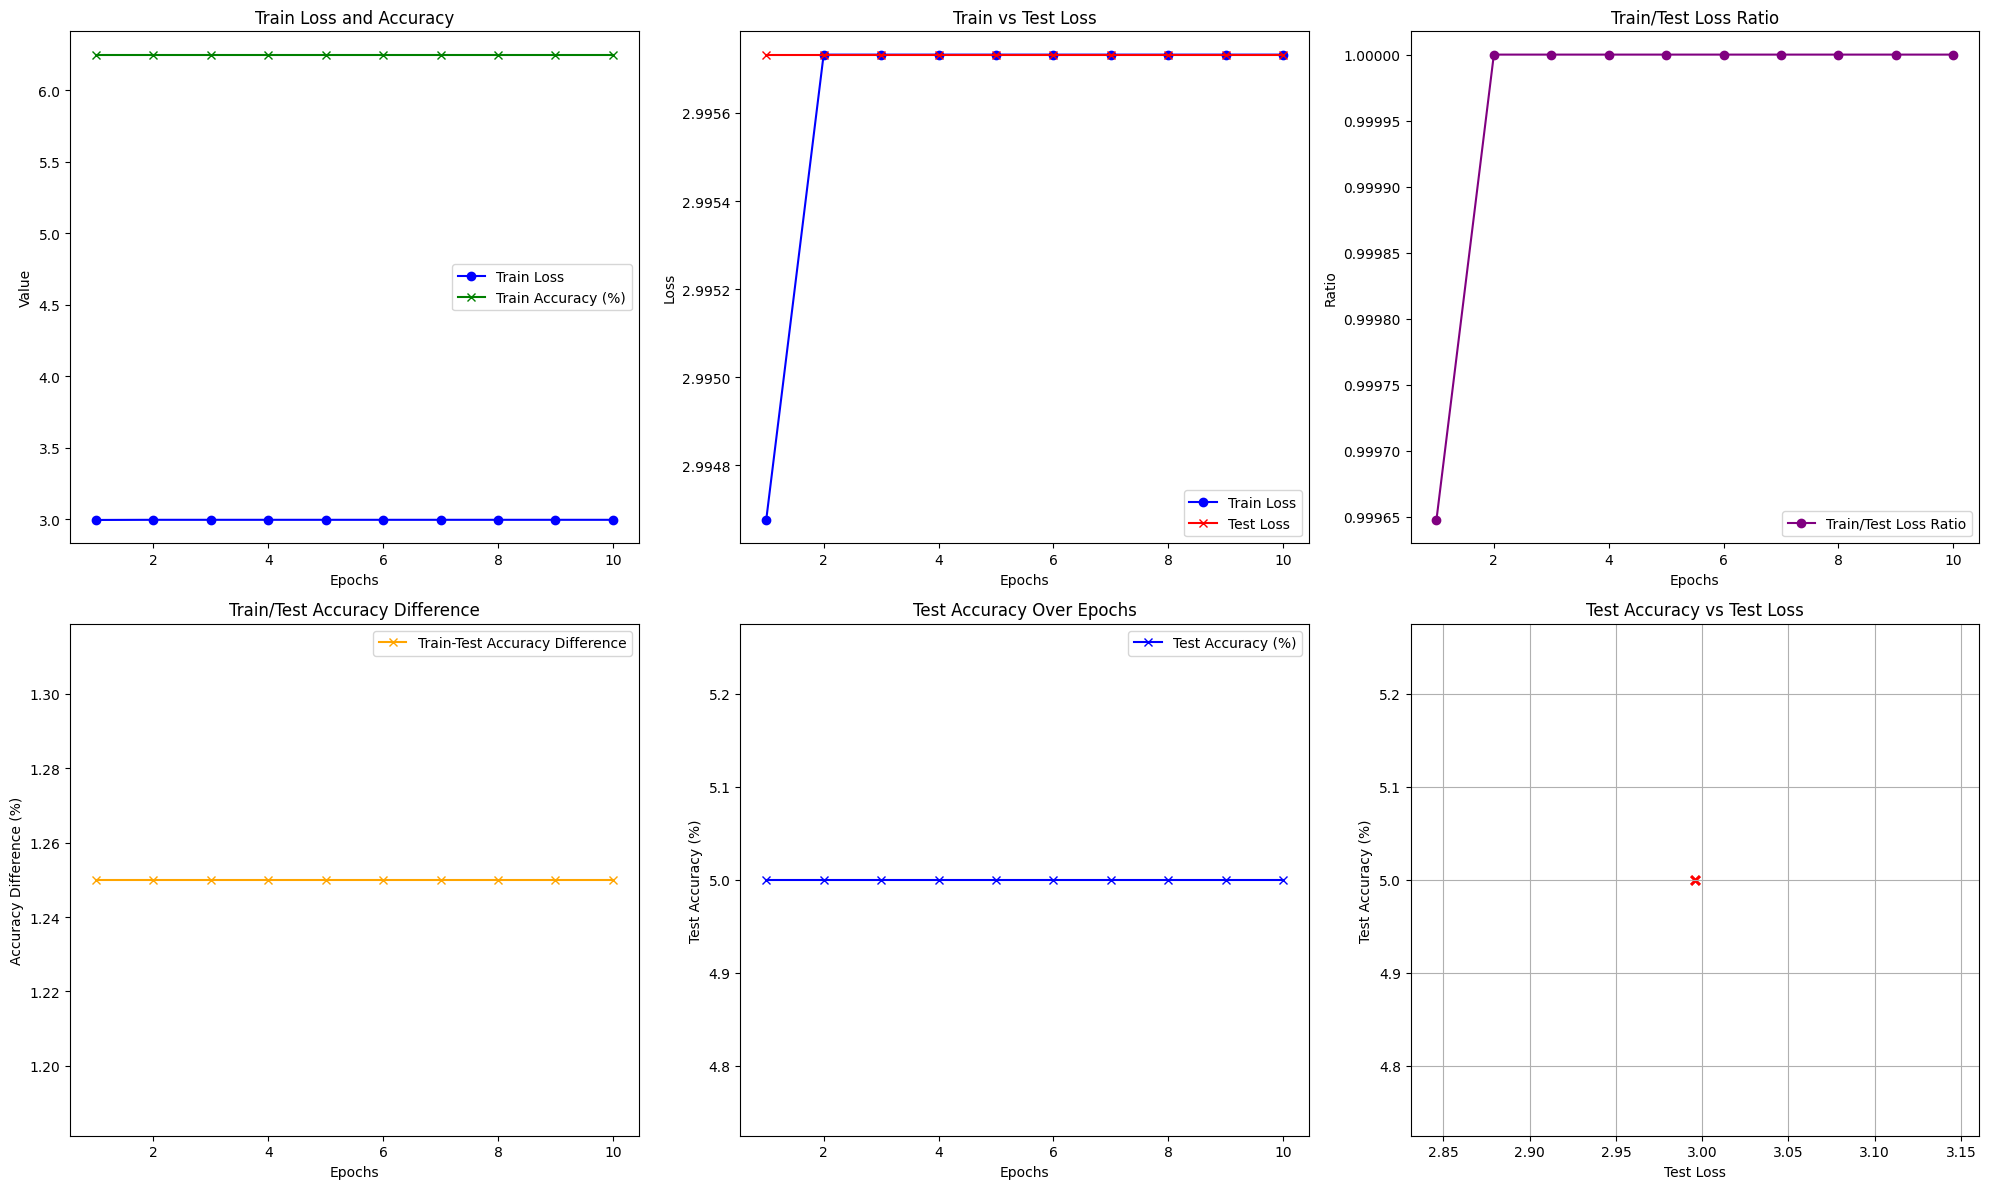

In [51]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):

    model.train() 
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for i, (spike_batch, label_batch) in enumerate(train_loader):

        spike_batch = spike_batch.to(device)
        label_batch = label_batch.to(device)

        outputs = model(spike_batch)  

        outputs = outputs.mean(dim=1)  
        loss = criterion(outputs, label_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        correct_train += (outputs.argmax(dim=1) == label_batch).sum().item()
        total_train += label_batch.size(0)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    

    train_loss = running_train_loss / len(train_loader)
    train_accuracy = (correct_train / total_train) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    model.eval()  
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for spike_batch, label_batch in test_loader:
            spike_batch = spike_batch.to(device)
            label_batch = label_batch.to(device)

            outputs = model(spike_batch)
            outputs = outputs.mean(dim=1)
            loss = criterion(outputs, label_batch)

            running_test_loss += loss.item()
            correct_test += (outputs.argmax(dim=1) == label_batch).sum().item()
            total_test += label_batch.size(0)
    
    test_loss = running_test_loss / len(test_loader)
    test_accuracy = (correct_test / total_test) * 100
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Assuming your code for training loop remains the same

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(20, 12))

# 1. Train Loss and Accuracy Plot
plt.subplot(2, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(epochs, train_accuracies, label='Train Accuracy (%)', color='green', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Train Loss and Accuracy')
plt.legend()

# 2. Train vs Test Loss Plot
plt.subplot(2, 3, 2)
plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', color='red', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()

# 3. Train/Test Loss Ratio Plot
train_test_loss_ratio = [train_loss / test_loss if test_loss != 0 else 0 for train_loss, test_loss in zip(train_losses, test_losses)]
plt.subplot(2, 3, 3)
plt.plot(epochs, train_test_loss_ratio, label='Train/Test Loss Ratio', color='purple', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Ratio')
plt.title('Train/Test Loss Ratio')
plt.legend()

# 4. Train/Test Accuracy Difference Plot
train_test_accuracy_diff = [train_accuracy - test_accuracy for train_accuracy, test_accuracy in zip(train_accuracies, test_accuracies)]
plt.subplot(2, 3, 4)
plt.plot(epochs, train_test_accuracy_diff, label='Train-Test Accuracy Difference', color='orange', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Difference (%)')
plt.title('Train/Test Accuracy Difference')
plt.legend()

# 5. Test Accuracy Over Epochs Plot (Added to the Subplot)
plt.subplot(2, 3, 5)
plt.plot(epochs, test_accuracies, label='Test Accuracy (%)', color='blue', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

# 6. New Insightful Graph: Test Accuracy vs Test Loss
plt.subplot(2, 3, 6)
plt.scatter(test_losses, test_accuracies, color='red', marker='x')
plt.xlabel('Test Loss')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy vs Test Loss')
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()